# Installation and Imports

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import math
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import time
import tracemalloc
from tensorflow.keras.regularizers import l2

In [5]:
import scvi

Global seed set to 0


In [6]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

scanpy==1.9.6 anndata==0.9.2 umap==0.5.7 numpy==1.19.5 scipy==1.10.1 pandas==1.4.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


# Defined Methods

## Data Preprocessing

In [7]:
def data_init(path):
    print("\n==========================  Data Initialization  =================================\n")
    data = pd.read_csv(path, index_col=0).astype('float64')
    clusters = data.columns
    clusters = [int(x) for x in [float(x) for x in clusters]]
    adata = sc.AnnData(X=(data.values.T))
    adata.var_names = data.index
    adata.obs_names = [f"cell-{i}" for i in range(1, len(clusters) + 1)]
    adata.obs["cluster"] = clusters
    print("Loaded Dataset Structure: ")
    print((pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index)).iloc[:10, :10])
    print(adata)
    print(f'Total Clusters: \n{np.unique(adata.obs["cluster"])}')
    print(f'Clusters: \n{adata.obs["cluster"]}')
    sc.pp.pca(adata, n_comps=50) 
    sc.pp.neighbors(adata, n_pcs=50)
    sc.tl.umap(adata)
    print("Existing Cluster")
    sc.pl.umap(adata, color='cluster')
    return adata


In [8]:
def data_processing(adata):
  print("\n==========================  Data Processing  =================================\n")
  sc.pp.filter_cells(adata, min_genes=200)
  sc.pp.filter_genes(adata, min_cells=3)
  sc.pp.normalize_per_cell(adata)
  sc.pp.log1p(adata, copy=True)
  return adata


## Denoising

In [9]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import numpy as np

def Denoise(adata):
    
    # Step 1: Load and preprocess data
    X = adata.X  # Assuming adata.X is in sparse format
    X = X.toarray() if hasattr(X, "toarray") else X  # Convert to dense if sparse
    
    # Normalize and scale data
    X = sc.pp.log1p(X, copy=True)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Step 2: Add sparse noise to mimic biological dropout
    def add_sparse_noise(data, dropout_rate=0.1):
        """
        Adds sparse dropout noise to mimic missing data in scRNA-seq.
        """
        noisy_data = data.copy()
        mask = np.random.binomial(1, dropout_rate, size=data.shape)  # Create dropout mask
        noisy_data[mask == 1] = 0  # Set selected values to zero
        return noisy_data
    
    X_noisy = add_sparse_noise(X)
    
    # Step 3: Define sparse-aware denoising autoencoder
    input_dim = X.shape[1]
    
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    latent_space = Dense(128, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(512, activation='relu')(latent_space)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    
    # Custom sparse-aware loss
    def sparse_mse(y_true, y_pred):
        """
        Custom loss to preserve zeros and penalize large changes to nonzero values.
        """
        mask = tf.cast(tf.equal(y_true, 0.0), tf.float32)  # Mask for zeros in original data
        nonzero_loss = tf.reduce_mean(tf.square((1 - mask) * (y_true - y_pred)))  # Penalize changes to nonzeros
        zero_loss = tf.reduce_mean(tf.square(mask * y_pred))  # Penalize predicted values where true value is zero
        return nonzero_loss + 0.1 * zero_loss  # Combine losses with weight for zero preservation
    
    # Compile the model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                        loss=sparse_mse,
                        metrics=['mae'])
    
    # Step 4: Train the model
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
    X_noisy_train, X_noisy_val = train_test_split(X_noisy, test_size=0.2, random_state=42)
    
    history = autoencoder.fit(
        X_noisy_train, X_train,
        validation_data=(X_noisy_val, X_val),
        epochs=200,
        batch_size=256,
        shuffle=True,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        ]
    )
    
    # Step 5: Denoise the data
    X_denoised = autoencoder.predict(X_noisy)
    
    # Save the denoised output
    adata.X = scaler.inverse_transform(X_denoised)  # Inverse scaling
    return adata


## Clustering

In [10]:
def cluster_with_louvain(adata, epochs, resolution=2.5):
  print("\n========================== Clustering With Louvain =================================\n")
  # if "X_pca" not in adata.obsm and "neighbors" not in adata.uns:
  sc.pp.pca(adata, n_comps=50)
  sc.pp.neighbors(adata, n_pcs=50)

  for i in range(0, epochs):
    sc.tl.louvain(adata, resolution)

    print(f"\nClustering epoch {i+1} ------------------")
    ari = adjusted_rand_score(adata.obs['cluster'], adata.obs['louvain'])
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")

    nmi = normalized_mutual_info_score(adata.obs['cluster'], adata.obs['louvain'])
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}\n")
  sc.tl.umap(adata)
  sc.pl.umap(adata, color='louvain')
  return adata



## Identify Marker Gene

### CellTICS

In [11]:
# Define fphi - High markers
def fphi(x):

    # Step 1: Normalized by max value (x + 1) / (max(x) + 1)
    normalized = (x + 1).div(x.max(axis=1) + 1, axis=0)

    # Step 2: Suppression factor (zt)
    zt = (1 - normalized).sum(axis=1) / (x.shape[1] - 1)

    # Step 3: phi values after applying suppression factor
    zp = normalized.mul(zt, axis=0)

    return zp

# Define frho - Low markers
def frho(x):
    # Step 1: Normalized by min value (1 / (x + 1)) * (min(x) + 1)
    normalized = (1 / (x + 1)).mul(x.min(axis=1) + 1, axis=0)

    # Step 2: Enhancement factor (zt)
    zt = (1 - normalized).sum(axis=1) / (x.shape[1] - 1)

    # Step 3: rho values after applying enhancement factor
    zp = normalized.mul(zt, axis=0)

    return zp



# thr1 -> high marker quantile | thr2 -> Low marker quantile
def CellTICS_marker_genes(adata, thr1=0.95, thr2=0.9):
  print("\n====================== Identify Marker Gene With CellTICS ============================\n")
  print("Expression Values of Genes: \n")
  expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
  louvain_labels = pd.Series(adata.obs['louvain'].values, index=adata.obs_names)
  print(expr_data.iloc[:10, :10])
  print(adata)

  print("\nAverage the cell expr data according to the clusters:\n")
  avg_expr_data = expr_data.T.groupby(louvain_labels).mean().T
  print(avg_expr_data.iloc[:10, :])

  phi = fphi(avg_expr_data)
  rho = frho(avg_expr_data)


  gnm = phi.index.values 
  ctpnm = phi.columns.values


  phi = np.array(phi)
  rho = np.array(rho)


  nummkg1 = math.ceil((1 - thr1) * phi.shape[0]) 
  nummkg2 = math.ceil((1 - thr2) * phi.shape[0]) 


  alpha = [] 
  beta = []
  for i in range(0, phi.shape[1]):
      alpha.append(np.quantile(phi[:, i], thr1))
      beta.append(np.quantile(rho[:, i], thr2))



  mkh = [] 
  mkl = [] 
  for i in range(0, phi.shape[1]):
      high_markers = gnm[phi[:, i] >= alpha[i]][0:nummkg1]
      low_markers = gnm[rho[:, i] >= beta[i]][0:nummkg2]
      mkh = np.concatenate([mkh, high_markers], axis=0) if len(mkh) > 0 else high_markers
      mkl = np.concatenate([mkl, low_markers], axis=0) if len(mkl) > 0 else low_markers


  mkh = mkh.reshape(nummkg1, phi.shape[1])
  mkl = mkl.reshape(nummkg2, rho.shape[1])
  mkh = pd.DataFrame(mkh, columns=ctpnm)
  mkl = pd.DataFrame(mkl, columns=ctpnm)

  print("\nHigh Marker Genes for each cluster/type: \n")
  print(mkh.iloc[:10, :])

  print("\nLow Marker Genes for each cluster/type: \n")
  print(mkl.iloc[:10, :])

  return mkh, mkl



In [12]:
# getting list of all high and low marker genes
def get_unique_marker_genes(high_markers):
  unique_high_markers = high_markers
  unique_high_markers = pd.unique(unique_high_markers.values.ravel()).tolist()
  print(f"\nTotal Unique High Marker Gene for all together {len(unique_high_markers)}: ")
  return unique_high_markers



## Unified Marker Genes (Weight Based)

In [47]:
from collections import defaultdict

def score_marker_genes(celltics_genes, smash_genes, cosg_genes, weights):
    
    gene_scores = defaultdict(float)
    
    for gene in celltics_genes:
        gene_scores[gene] += weights['celltics']
        
    for gene in smash_genes:
        gene_scores[gene] += weights['smash']
        
    for gene in cosg_genes:
        gene_scores[gene] += weights['cosg']
    
    sorted_genes = sorted(gene_scores.items(), key=lambda x: x[1], reverse=True)
    
    return [gene for gene, score in sorted_genes]


# Implementations____________


==========================  Data Initialization  =================================

Loaded Dataset Structure: 
             A1BG        A2M      A2ML1  A2MP1    A4GALT        AAAS        AACS    AACSP1       AADAT      AAED1
cell-1   0.202546  20.457146   0.000000    0.0  0.000000    0.000000    0.000000  3.848374    0.202546   0.000000
cell-2   0.000000   0.000000   0.000000    0.0  0.000000    0.000000   21.869059  0.000000    1.792546   0.000000
cell-3   0.000000   0.000000   0.000000    0.0  0.000000    0.000000    0.000000  0.000000    6.664026   0.000000
cell-4   0.000000   0.000000   0.000000    0.0  0.000000   84.884320    0.000000  0.000000  101.198424   0.000000
cell-5   0.000000   0.000000   8.079571    0.0  0.000000    0.000000  162.867142  0.000000  121.618806   0.000000
cell-6   0.000000   0.000000  16.811503    0.0  0.000000  111.964612    2.017380  0.000000   20.173804   0.000000
cell-7   0.000000   0.000000   0.000000    0.0  0.000000    0.000000  390.598964  0.000000

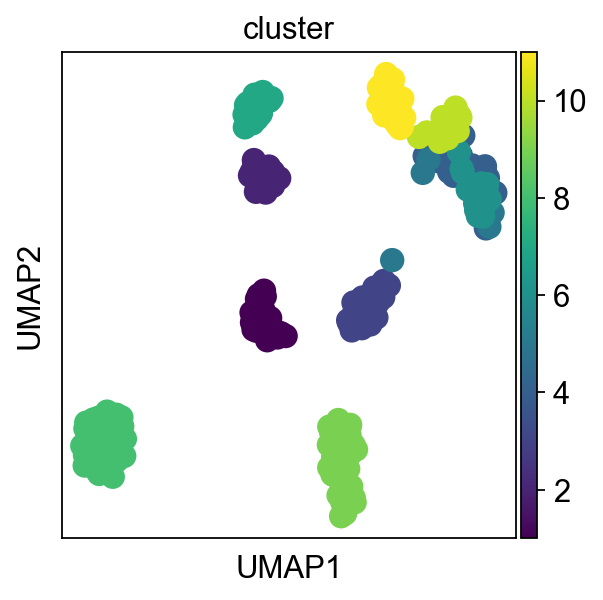


==========================  Data Processing  =================================

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 1.2706 - mae: 0.9440 - val_loss: 1.1847 - val_mae: 0.9104
Epoch 2/200
1/1 [==============================] - 0s 184ms/step - loss: 1.2645 - mae: 0.9418 - val_loss: 1.1634 - val_mae: 0.9021
Epoch 3/200
1/1 [==============================] - 0s 182ms/step - loss: 1.2435 - mae: 0.9344 - val_loss: 1.1253 - val_mae: 0.8861
Epoch 4/200
1/1 [==============================] - 0s 170ms/step - loss: 1.2204 - mae: 0.9261 - val_loss: 1.0861 - val_mae: 0.8673
Epoch 5/200
1/1 [==============================] - 0s 206ms/step - loss: 1.1960 - mae: 0.9168 - val_loss: 1.0608 - val_mae: 0.8526
Epoch 6/200
1/1 [==============================] - 0s 193ms/step - loss: 1.1742 - mae: 0.9082 - val_loss: 1.0493 -

In [16]:
dataset_path = "../../data/Pollen.csv"

adata = data_init(dataset_path)

adata = data_processing(adata)

adata = Denoise(adata)

# CellTICS Marker Genes


========================== Clustering With Louvain =================================

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)

Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.9561
Normalized Mutual Information (NMI): 0.9664

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


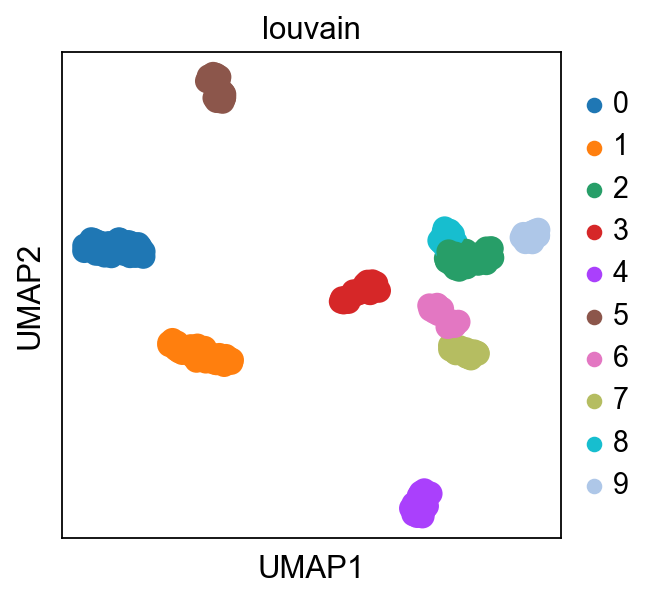


====================== Identify Marker Gene With CellTICS ============================

Expression Values of Genes: 

          cell-1    cell-2    cell-3    cell-4    cell-5    cell-6    cell-7    cell-8    cell-9   cell-10
A1BG    0.553064  0.576758  0.524349  0.511248  0.524755  0.516863  0.524940  0.513402  0.532495  0.515141
A2M     1.201530  0.752149  0.952281  0.613840  0.446230  0.539795  0.512139  0.582299  0.550502  0.526454
A2ML1   0.535839  0.328087  0.326999  0.396330  0.476971  0.486543  0.385330  0.364043  0.430290  0.409239
A2MP1   0.327428  0.536325  0.502409  0.269835  0.210776  0.238268  0.213951  0.304596  0.271717  0.262164
A4GALT  0.200058  0.170516  0.172212  0.207155  0.290160  0.263194  0.196932  0.234628  0.341205  0.289647
AAAS    2.681307  2.660017  2.761724  2.930988  3.131079  2.952951  2.897829  2.862705  2.940964  3.028412
AACS    1.536521  1.657506  1.491939  1.793170  1.947438  1.671320  1.823524  2.190278  1.850287  1.956435
AACSP1  0.522091  0.30153

In [26]:
cluster_with_louvain(adata, epochs=1, resolution=2.15)
t=time.process_time()
tracemalloc.start()

high_markers, low_markers = CellTICS_marker_genes(adata, thr1=0.97, thr2= 0.95)

current, peak = tracemalloc.get_traced_memory()
print(f'Memory Usage: {(peak / (1024 ** 2)):.2f} Mb') #The output is given in form of (current, peak), i.e., current memory is the memory the code is currently using,uses and peak memory is the maximum space the program used while executing.
print(f'Required Time: {time.process_time() - t} sec')
tracemalloc.stop()


high_markers = get_unique_marker_genes(high_markers)

# Cluster Reconstructed Dataset (CellTICS)

In [18]:
expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
expr_data = expr_data.loc[high_markers]
expr_data.shape

rcdata = sc.AnnData(X=expr_data.values.T)
rcdata.var_names = expr_data.index
rcdata.obs_names = expr_data.columns
rcdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(rcdata)


Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 249 × 3186
    obs: 'cluster'


In [118]:
# rc_pd = pd.DataFrame(rcdata.X.T, index=rcdata.var_names, columns=rcdata.obs_names)
# rc_pd.to_csv('rc_processed.csv')


========================== Clustering With Louvain =================================

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)

Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.9561
Normalized Mutual Information (NMI): 0.9664

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


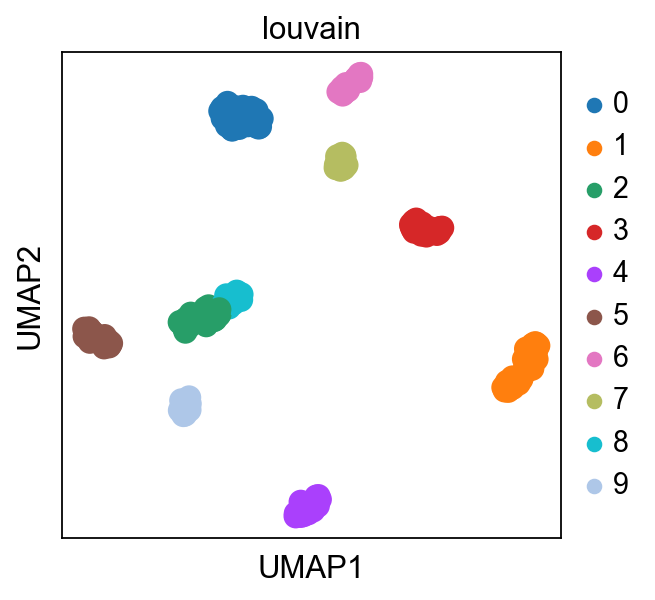

AnnData object with n_obs × n_vars = 249 × 3186
    obs: 'cluster', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
cluster_with_louvain(rcdata, epochs=1, resolution=1.6)

# Smash Marker Genes

 * Initialising ...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                473792    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None,

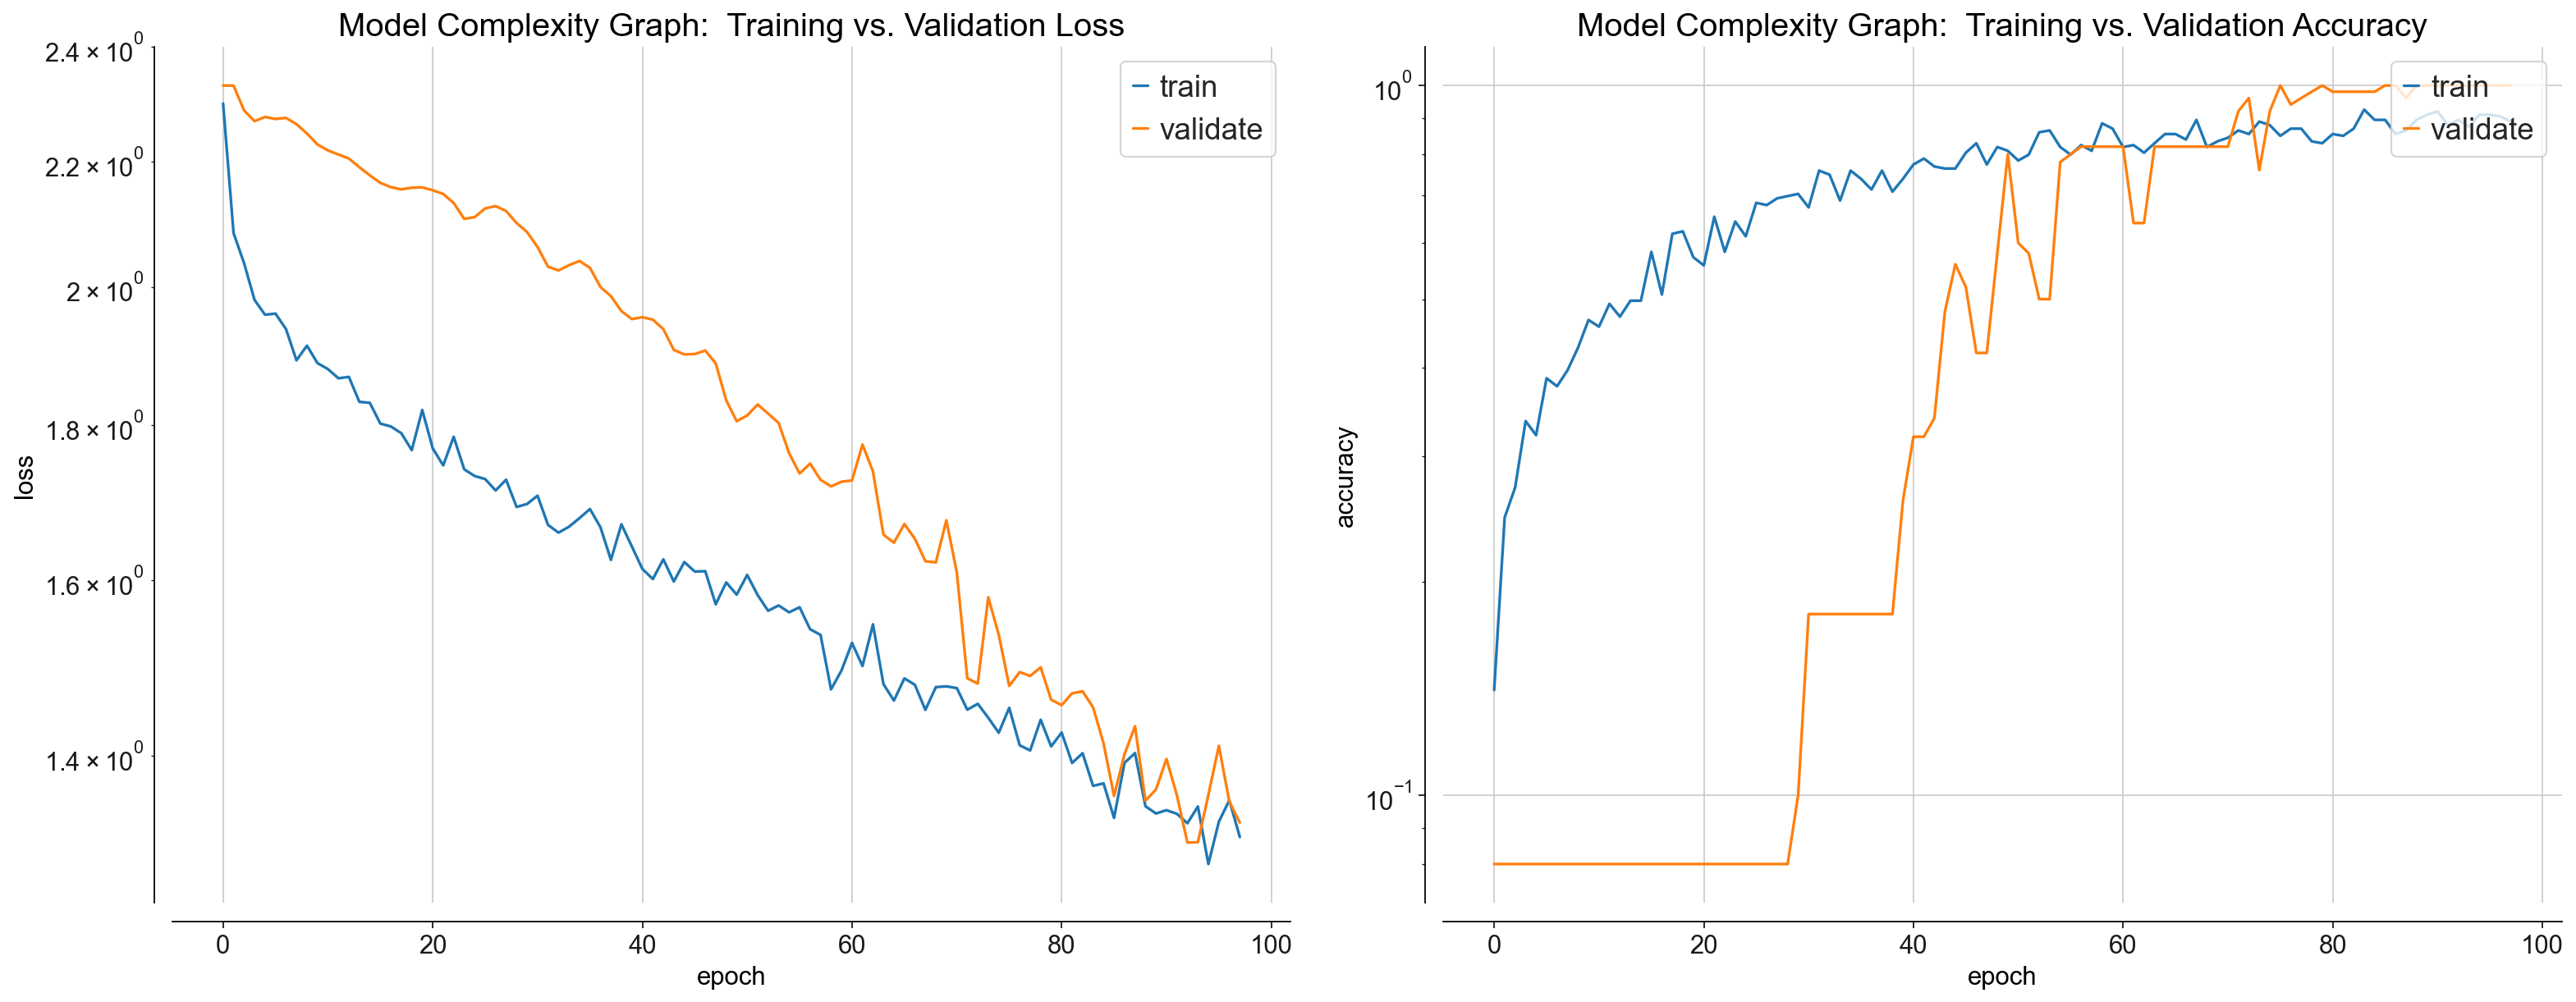

<Figure size 320x320 with 0 Axes>

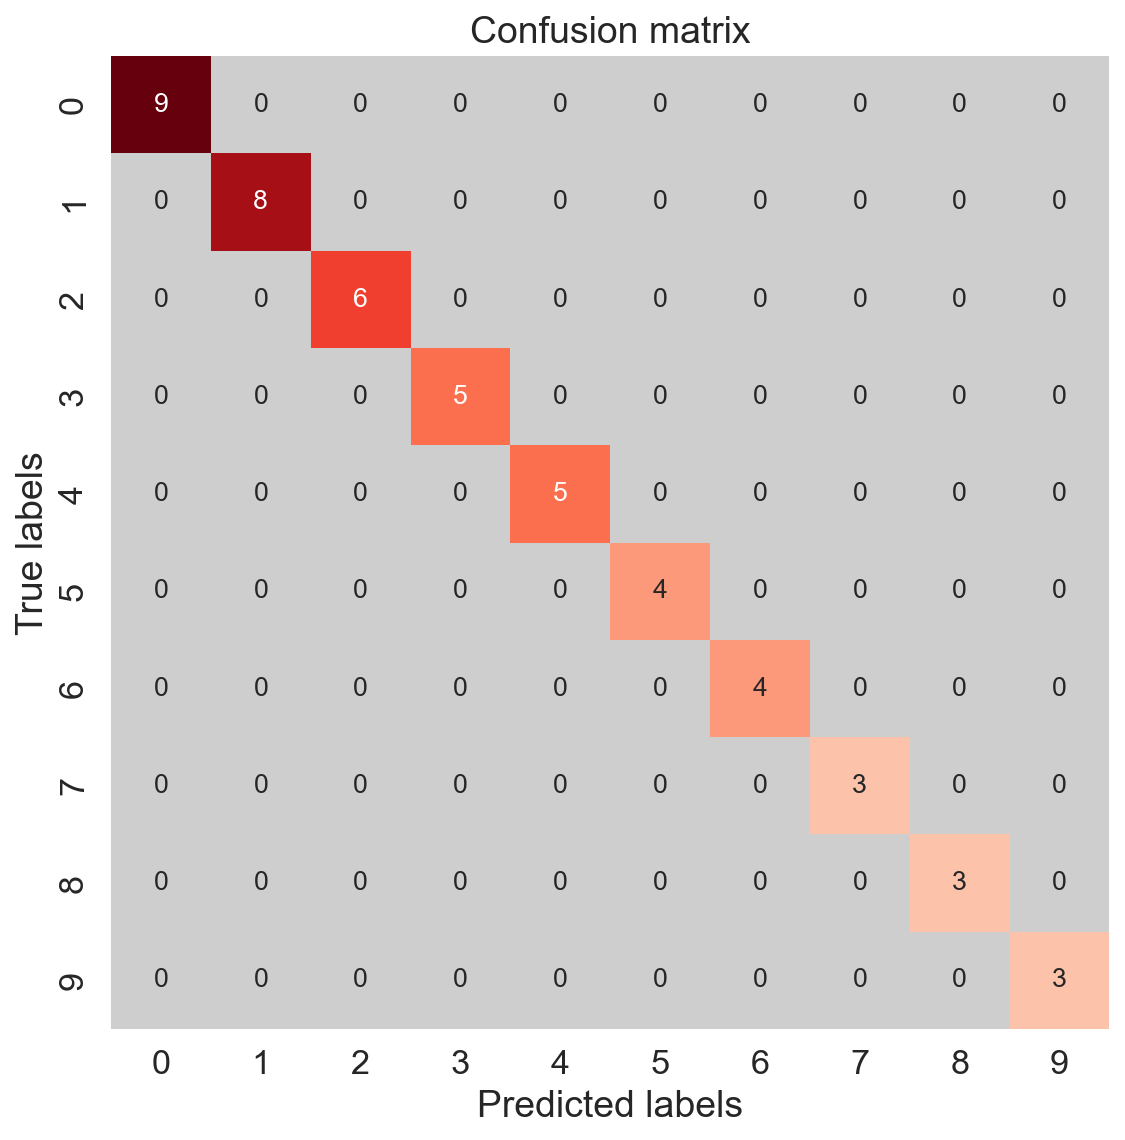

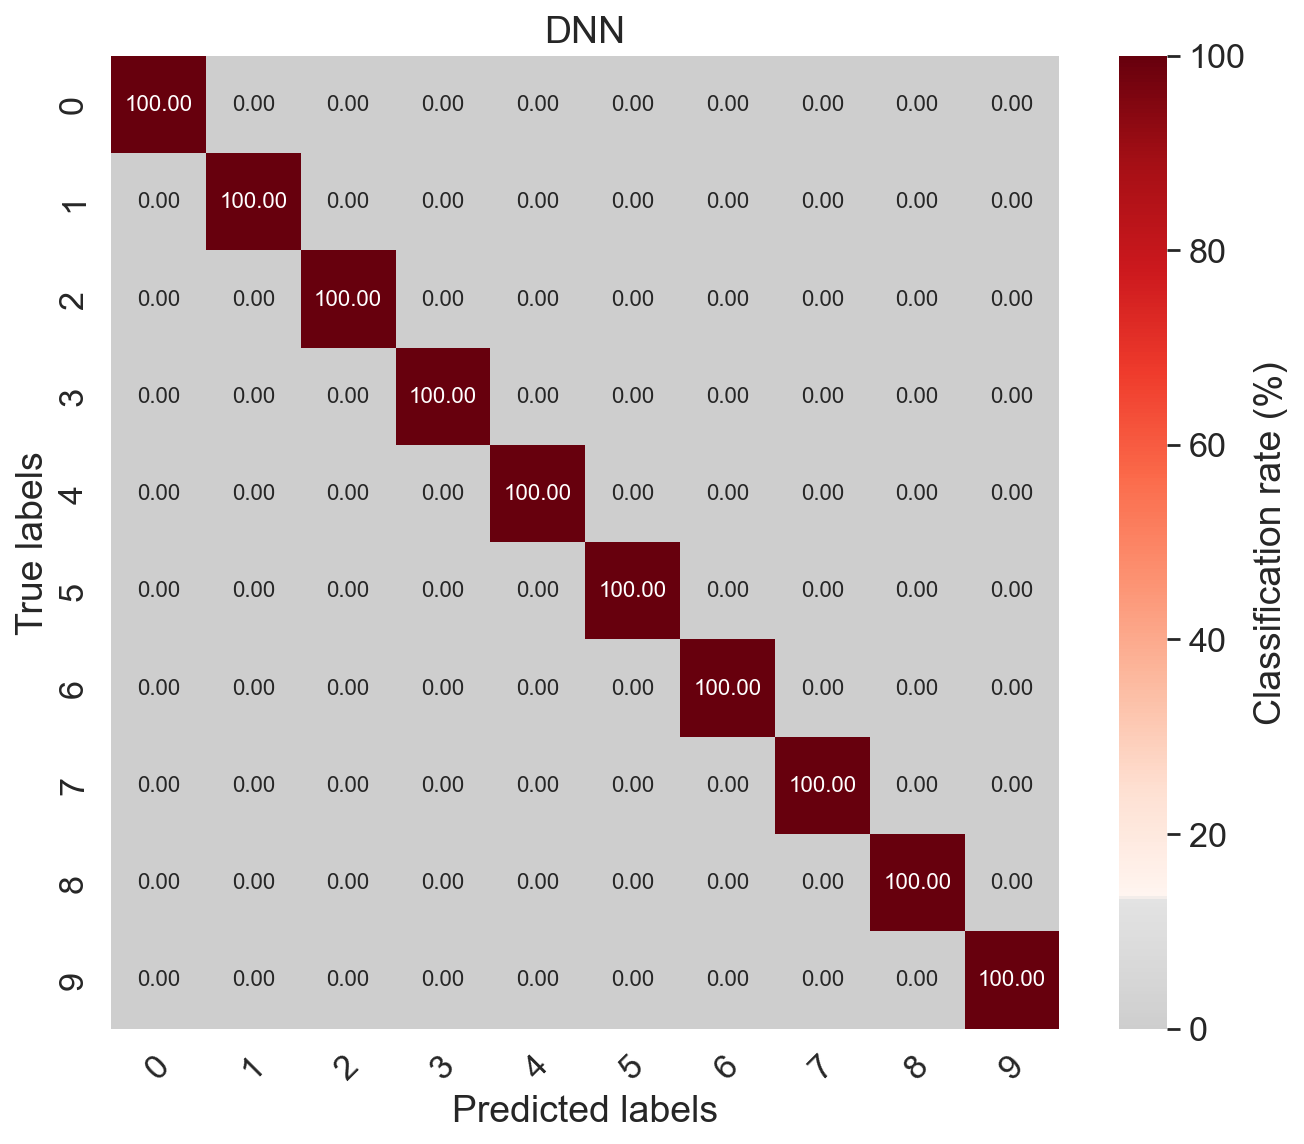

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

2/2 [==============================] - 0s 3ms/step - loss: 1.3107 - accuracy: 1.0000 - auc: 0.9997 - precision: 0.0000e+00 - recall: 0.0000e+00


In [27]:
import os
import smashpy

smash = smashpy.smashpy()

if np.any(np.isnan(adata.X)):
    adata.X = np.nan_to_num(adata.X)

if not os.path.exists('Figures'):
    os.makedirs('Figures')

smash.DNN(adata, group_by='louvain')

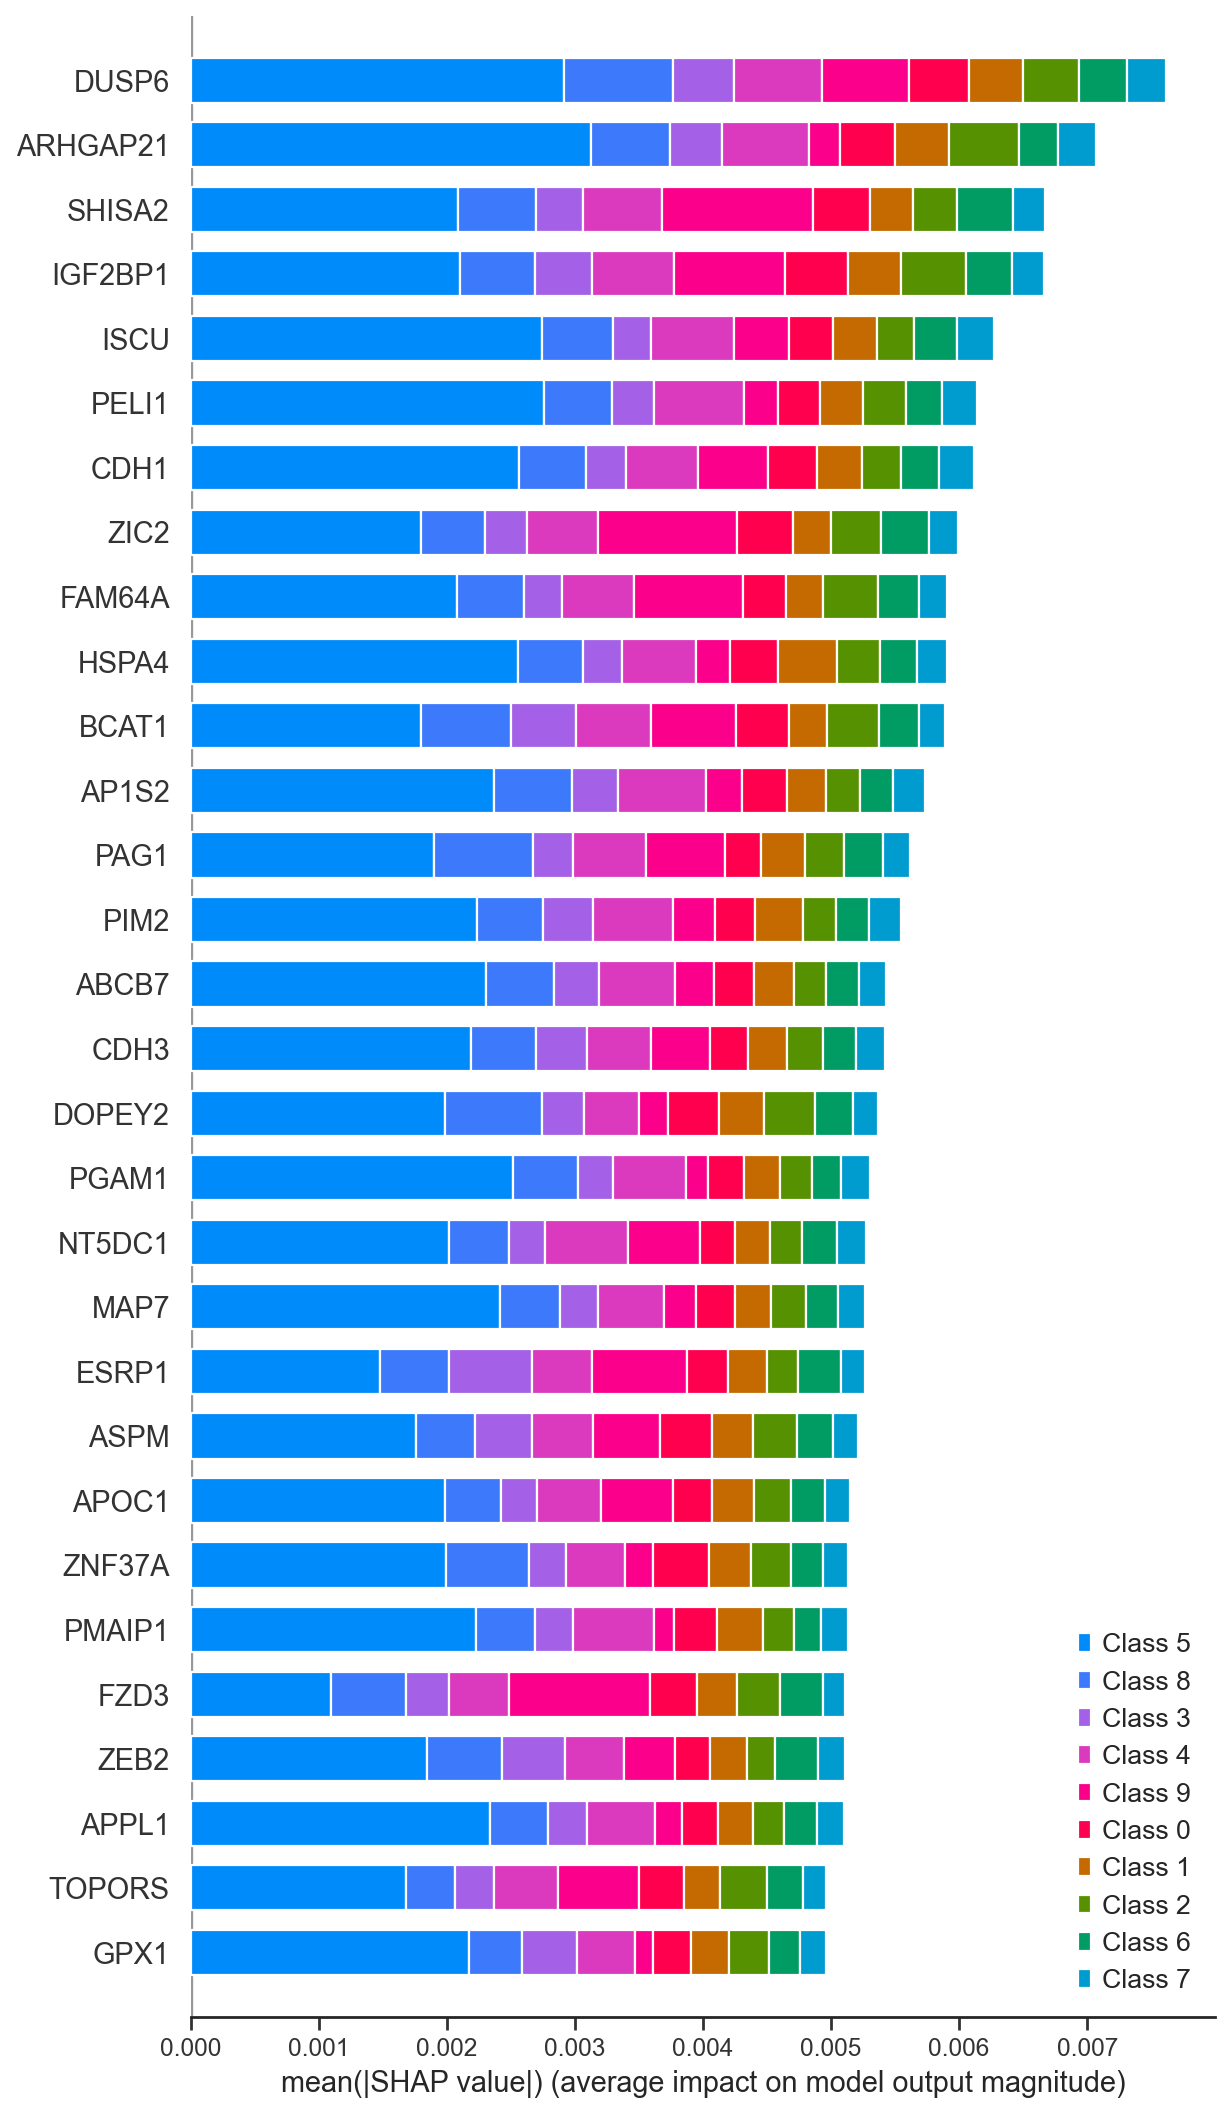

Memory Usage: 138.96 Mb
Required Time: 16.78125 sec


In [28]:

thr=0.95
n_genes = math.ceil((1 - thr) * adata.var.shape[0])


t=time.process_time()
tracemalloc.start()
# Run SHAP to identify marker genes
selected_genes, selected_genes_dict = smash.run_shap(adata, group_by='louvain', pct=0.5, restrict_top=("global", n_genes))

current, peak = tracemalloc.get_traced_memory()
print(f'Memory Usage: {(peak / (1024 ** 2)):.2f} Mb') #The output is given in form of (current, peak), i.e., current memory is the memory the code is currently using,uses and peak memory is the maximum space the program used while executing.
print(f'Required Time: {time.process_time() - t} sec')
tracemalloc.stop()

# Cluster Reconstructed Dataset (SMaSH)


Total Marker genes (741): 

Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 249 × 741
    obs: 'cluster'

========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.9561
Normalized Mutual Information (NMI): 0.9664



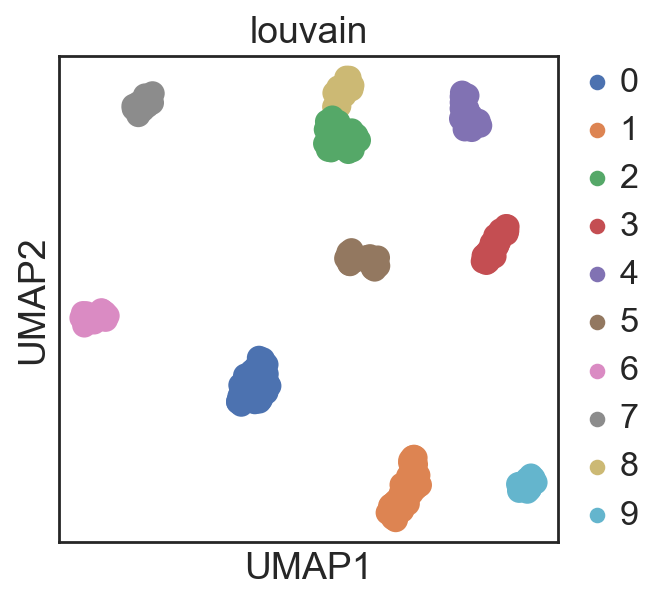

AnnData object with n_obs × n_vars = 249 × 741
    obs: 'cluster', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:

print(f'\nTotal Marker genes ({len(selected_genes)}): ')
expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
# expr_data.to_csv('expr_processed.csv')
# expression data with only marker genes
expr_data = expr_data.loc[selected_genes]
expr_data.shape

rcdata = sc.AnnData(X=expr_data.values.T)
rcdata.var_names = expr_data.index
rcdata.obs_names = expr_data.columns
rcdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(rcdata)
rc_pd = pd.DataFrame(rcdata.X.T, index=rcdata.var_names, columns=rcdata.obs_names)
# rc_pd.to_csv('rc_processed.csv')

if "X_pca" not in rcdata.obsm and "neighbors" not in rcdata.uns:
  sc.pp.pca(rcdata, n_comps=50)
  sc.pp.neighbors(rcdata, n_pcs=50)
cluster_with_louvain(rcdata, epochs=1, resolution=1.5)

# Cosg Marker Genes

In [30]:
import cosg as cosg
import importlib
importlib.reload(cosg)

<module 'cosg' from 'D:\\FYDP\\Implementation\\Notebooks\\python3.8\\lib\\site-packages\\cosg\\__init__.py'>

In [31]:
t=time.process_time()
tracemalloc.start()

cosg.cosg(adata,
    key_added='cosg',
        mu=1,
        n_genes_user=100,
               groupby='louvain')

current, peak = tracemalloc.get_traced_memory()
print(f'Memory Usage: {(peak / (1024 ** 2)):.2f} Mb') #The output is given in form of (current, peak), i.e., current memory is the memory the code is currently using,uses and peak memory is the maximum space the program used while executing.
print(f'Required Time: {time.process_time() - t} sec')
tracemalloc.stop()

**finished identifying marker genes by COSG**
Memory Usage: 57.43 Mb
Required Time: 0.265625 sec


In [32]:
adata

AnnData object with n_obs × n_vars = 249 × 14805
    obs: 'cluster', 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'cosg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
# cosg_marker_genes = np.unique(np.array(adata.uns['cosg']['names'])).tolist()
cosg_marker_genes = pd.unique(pd.DataFrame(adata.uns['cosg']['names']).values.ravel()).tolist()

In [34]:
len(cosg_marker_genes)

985

# Cluster Reconstructed Dataset (Cosg)

In [35]:
cosg_expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
# expr_data.to_csv('expr_processed.csv')
# expression data with only high marker genes
cosg_expr_data = cosg_expr_data.loc[cosg_marker_genes]
# expr_data = expr_data.loc[marker_genes]
cosg_expr_data.shape

cgdata = sc.AnnData(X=cosg_expr_data.values.T)
cgdata.var_names = cosg_expr_data.index
cgdata.obs_names = cosg_expr_data.columns
cgdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(cgdata)


Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 249 × 985
    obs: 'cluster'



========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.9506
Normalized Mutual Information (NMI): 0.9620



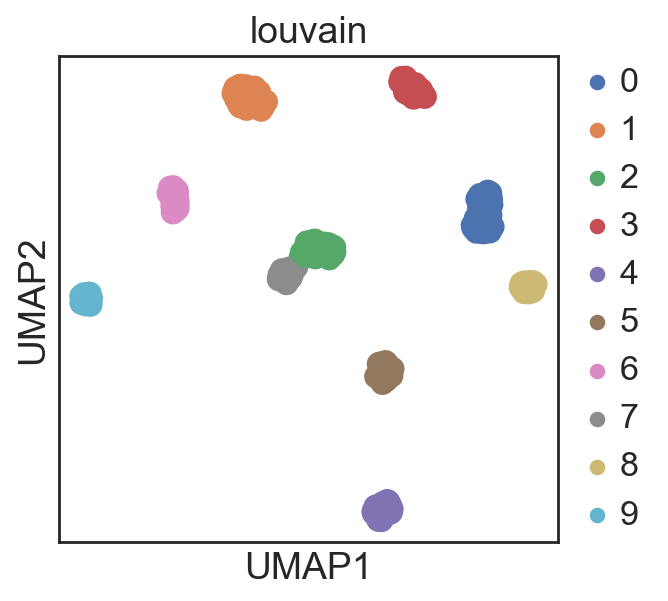

AnnData object with n_obs × n_vars = 249 × 985
    obs: 'cluster', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:

if "X_pca" not in cgdata.obsm and "neighbors" not in cgdata.uns:
  sc.pp.pca(cgdata, n_comps=50)
  sc.pp.neighbors(cgdata, n_pcs=50)
cluster_with_louvain(cgdata, epochs=1, resolution=1)

# Unified Marker Genes (CellTICS + COSG+ SMaSH)

In [48]:
weights = {
    'celltics': 1,
    'cosg': 0.8,
    'smash': 0.5
}
UMG = pd.unique(score_marker_genes(high_markers,cosg_marker_genes,selected_genes, weights))

In [49]:
len(UMG)

4301

In [50]:
exp_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
exp_data = exp_data.loc[UMG]

ccdata = sc.AnnData(X=exp_data.values.T)
ccdata.var_names = exp_data.index
ccdata.obs_names = exp_data.columns
ccdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(ccdata)


Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 249 × 4301
    obs: 'cluster'



========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.9561
Normalized Mutual Information (NMI): 0.9664



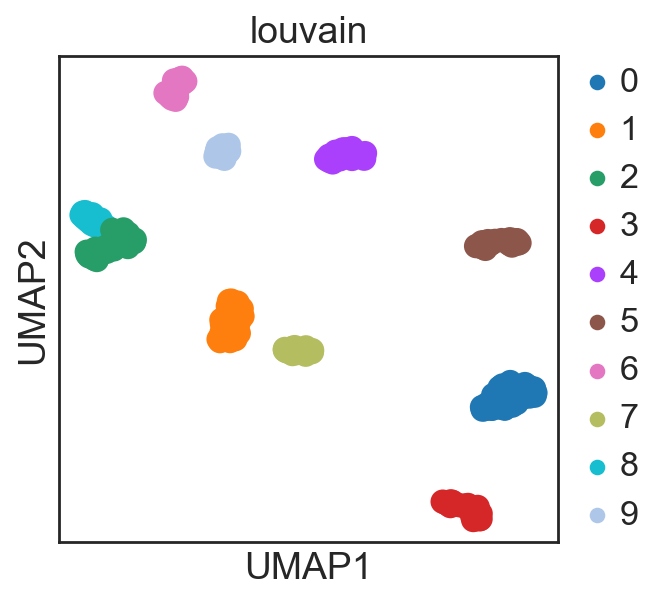

AnnData object with n_obs × n_vars = 249 × 4301
    obs: 'cluster', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [52]:

if "X_pca" not in ccdata.obsm and "neighbors" not in ccdata.uns:
  sc.pp.pca(ccdata, n_comps=50)
  sc.pp.neighbors(ccdata, n_pcs=50)
cluster_with_louvain(ccdata, epochs=1, resolution=1.8)